In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import random_statevector
from qiskit.circuit.library import Initialize

## Quantum Teleportation 
Alice wants to send an arbitrary quantum state (green) to her friend Bob using an entangled state they both share (violet-yellow).

![qtel](Figures/qtel.png)

##### Step 0: Prepare a random state

Prepare a random qubit using `random_statevector` and `seed=42`, and plot it on a bloch sphere.

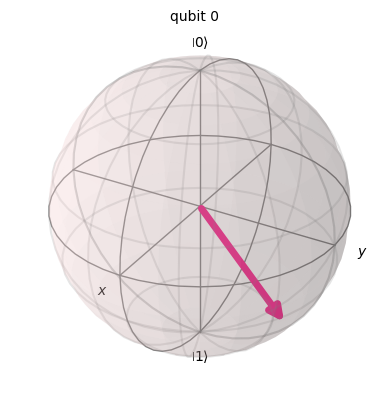

In [2]:
psi = random_statevector(2, seed=42)
plot_bloch_multivector(psi)

Initialize the state as instruction using `Initialize`.

In [3]:
init_gate = Initialize(psi)
init_gate.label = 'init'

##### Step 1: Set up the quantum circuit for teleportation

We need 3 qubits: q0, q1 (Alice's qubits) and q2 (Bob's qubit) 

In [4]:
qr = QuantumRegister(3, name='q')
crx = ClassicalRegister(1, name='crx')
crz = ClassicalRegister(1, name='crz')
circuit = QuantumCircuit(qr, crz, crx)

Append the `init_gate` at position `[0]`.

In [5]:
circuit.append(init_gate, [0])
circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

##### Step 2: Create the entanglement between q1 and q2

Add the required gates to the circuit discussed during the lecture

In [6]:
circuit.h(1)
circuit.cx(1, 2)
circuit.barrier()
circuit.draw()

┌──────────────────────────────────────────┐ ░            ░ 
  q_0: ┤ init(0.18817+0.46343j,-0.64223+0.58083j) ├─░────────────░─
       └──────────────────────────────────────────┘ ░ ┌───┐      ░ 
  q_1: ─────────────────────────────────────────────░─┤ H ├──■───░─
                                                    ░ └───┘┌─┴─┐ ░ 
  q_2: ─────────────────────────────────────────────░──────┤ X ├─░─
                                                    ░      └───┘ ░ 
crz: 1/════════════════════════════════════════════════════════════
                                                                   
crx: 1/════════════════════════════════════════════════════════════

##### Step 3: Perform the Bell measurement 

Alice now performs the most essential operations on her qubits (q0 and q1): the Bell measurement ❗️

In [7]:
circuit.cx(0, 1)
circuit.h(0)
circuit.barrier()
circuit.measure([0, 1], [0, 1])
circuit.barrier()
circuit.draw()

┌──────────────────────────────────────────┐ ░            ░      ┌───┐»
  q_0: ┤ init(0.18817+0.46343j,-0.64223+0.58083j) ├─░────────────░───■──┤ H ├»
       └──────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘»
  q_1: ─────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├─────»
                                                    ░ └───┘┌─┴─┐ ░ └───┘     »
  q_2: ─────────────────────────────────────────────░──────┤ X ├─░───────────»
                                                    ░      └───┘ ░           »
crz: 1/══════════════════════════════════════════════════════════════════════»
                                                                             »
crx: 1/══════════════════════════════════════════════════════════════════════»
                                                                             »
«        ░ ┌─┐    ░ 
«  q_0: ─░─┤M├────░─
«        ░ └╥┘┌─┐ ░ 
«  q_1: ─░──╫─┤M├─░─
«        ░  ║ └╥┘ ░ 
«  q_2: ─░──╫──╫──░─
«        ░  ║  ║  ░ 
«crz: 1/════╩══╬════
«           0  ║    
«crx: 1/═══════╩════
«              0

##### Step 4: Apply controlled operations on Bob's qubit 

Depending on the measurement outcomes (you already know them because you know which gates you applied on Alice's side 😉)

In [8]:
circuit.x(2).c_if(crx, 1)
circuit.z(2).c_if(crz, 1)
circuit.draw()

┌──────────────────────────────────────────┐ ░            ░      ┌───┐»
  q_0: ┤ init(0.18817+0.46343j,-0.64223+0.58083j) ├─░────────────░───■──┤ H ├»
       └──────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘»
  q_1: ─────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├─────»
                                                    ░ └───┘┌─┴─┐ ░ └───┘     »
  q_2: ─────────────────────────────────────────────░──────┤ X ├─░───────────»
                                                    ░      └───┘ ░           »
crz: 1/══════════════════════════════════════════════════════════════════════»
                                                                             »
crx: 1/══════════════════════════════════════════════════════════════════════»
                                                                             »
«        ░ ┌─┐    ░               
«  q_0: ─░─┤M├────░───────────────
«        ░ └╥┘┌─┐ ░               
«  q_1: ─░──╫─┤M├─░───────────────
«        ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
«  q_2: ─░──╫──╫──░──┤ X ├──┤ Z ├─
«        ░  ║  ║  ░  └─╥─┘  └─╥─┘ 
«           ║  ║       ║   ┌──╨──┐
«crz: 1/════╩══╬═══════╬═══╡ 0x1 ╞
«           0  ║    ┌──╨──┐└─────┘
«crx: 1/═══════╩════╡ 0x1 ╞═══════
«              0    └─────┘

##### Step 5: Run the circuit on the Aer backend 
 
Transpile the circuit for the Aer backend to run it using 'statevector_simulator'.

In [9]:
backend = Aer.get_backend('statevector_simulator')
mapped_circuit = transpile(circuit, backend)


job = backend.run(mapped_circuit)
result = job.result()
statevector= result.get_statevector()
counts = result.get_counts(mapped_circuit)

##### Step 6: Plot the results

Plot the results using a histogram

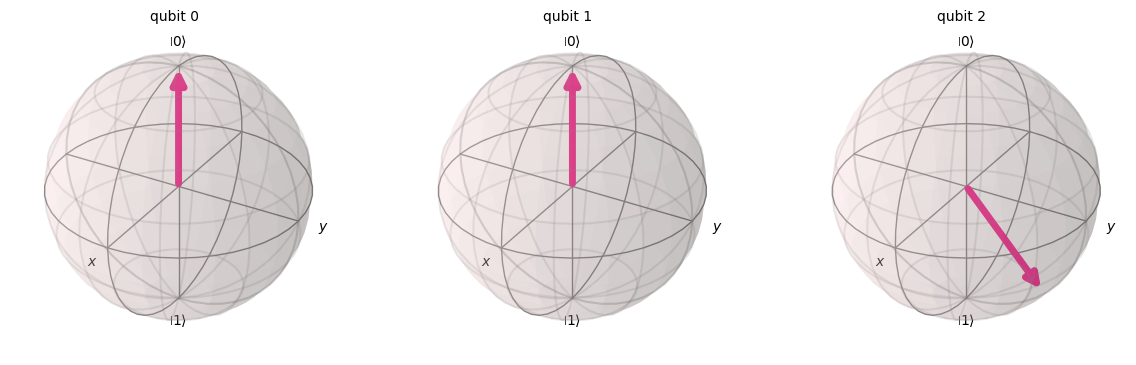

In [10]:
plot_bloch_multivector(statevector)